# SigLIP - Lung Cancer 4-Class Classification (Fixed)

**Dataset:** Lung Cancer 4 Types (Adenocarcinoma, Large Cell, Normal, Squamous Cell)
**Model:** google/siglip-base-patch16-224 — vision encoder ONLY (no OOM crash)
**Freeze:** first 50 named param tensors frozen, last ~50% trainable
**Fixes:** SiglipVisionModel only / batch=8 + grad accum / new autocast API / empty_cache after load


In [18]:
import os, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as T

try:
    import transformers
    print(f"Transformers : {transformers.__version__}")
except ImportError:
    os.system("pip install -q transformers>=4.38")
    import transformers

from transformers import SiglipVisionModel, SiglipProcessor

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, accuracy_score,
    f1_score, precision_score, recall_score,
)
from sklearn.preprocessing import label_binarize

print(f"PyTorch : {torch.__version__}")
print(f"CUDA    : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU     : {torch.cuda.get_device_name(0)}")
    print(f"VRAM    : {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")

from torchvision import datasets
from collections import Counter


Transformers : 5.2.0
PyTorch : 2.9.0+cu126
CUDA    : True
GPU     : Tesla P100-PCIE-16GB
VRAM    : 17.1 GB


In [19]:
class Config:
    DATA_DIR   =  "/kaggle/input/datasets/kabil007/lungcancer4types-imagedataset/Data"
    TRAIN_DIR  = os.path.join(DATA_DIR, "train")
    VAL_DIR    = os.path.join(DATA_DIR, "valid")
    TEST_DIR   = os.path.join(DATA_DIR, "test")
    OUTPUT_DIR = "/kaggle/working"

    CHECKPOINT   = "google/siglip-base-patch16-224"
    NUM_CLASSES  = 4
    CLASS_NAMES  = ["Adenocarcinoma", "Large Cell Carcinoma", "Normal", "Squamous Cell Carcinoma"]
    SHORT_NAMES  = ["Adeno", "Large Cell", "Normal", "Squamous"]
    FREEZE_FIRST_N = 50

    BATCH_SIZE    = 8
    GRAD_ACCUM    = 2
    NUM_EPOCHS    = 25
    LEARNING_RATE = 5e-5
    WEIGHT_DECAY  = 1e-5
    IMG_SIZE      = 224

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SEED   = 42

cfg = Config()

def set_seed(s):
    np.random.seed(s); torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)
print(f"Device  : {cfg.DEVICE}")
print(f"Model   : {cfg.CHECKPOINT}")
print(f"Classes : {cfg.CLASS_NAMES}")


Device  : cuda
Model   : google/siglip-base-patch16-224
Classes : ['Adenocarcinoma', 'Large Cell Carcinoma', 'Normal', 'Squamous Cell Carcinoma']


In [20]:
import os

for root, dirs, files in os.walk("/kaggle/input"):
    level = root.replace("/kaggle/input", "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")

input/
  datasets/
    kabil007/
      lungcancer4types-imagedataset/
        Data/
          valid/
            squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/
            normal/
            large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/
            adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/
          test/
            squamous.cell.carcinoma/
            normal/
            adenocarcinoma/
            large.cell.carcinoma/
          train/
            squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/
            normal/
            large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/
            adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/


## Data Exploration

Class distributions:

  Train:
    adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 195
    large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115
    normal: 148
    squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155

  Validation:
    adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 23
    large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 21
    normal: 13
    squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 15

  Test:
    adenocarcinoma: 120
    large.cell.carcinoma: 51
    normal: 54
    squamous.cell.carcinoma: 90


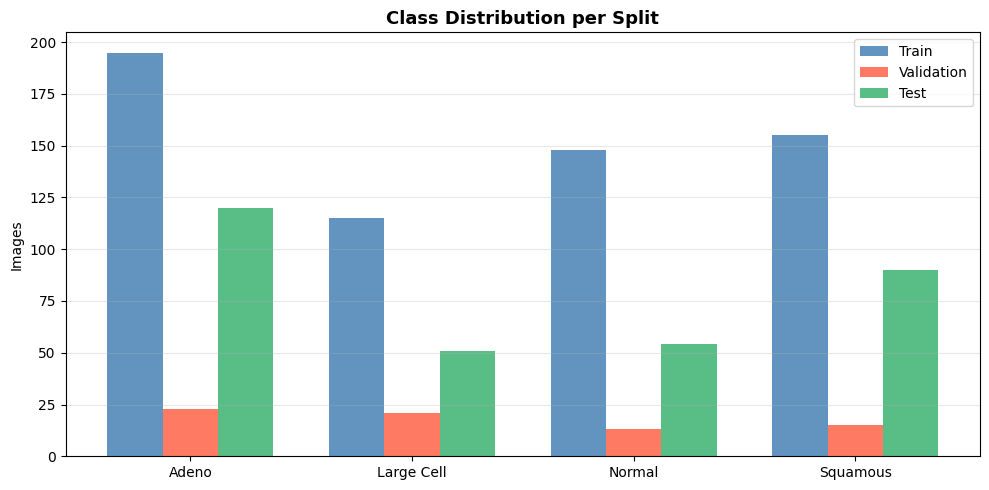

In [21]:
def get_dist(folder):
    ds = datasets.ImageFolder(folder)
    cnt = Counter(ds.targets)
    return ds.classes, [cnt[i] for i in range(len(ds.classes))]

splits = {"Train": cfg.TRAIN_DIR, "Validation": cfg.VAL_DIR, "Test": cfg.TEST_DIR}
dist_data = {}
print("Class distributions:")
for split, path in splits.items():
    classes, counts = get_dist(path)
    dist_data[split] = counts
    print(f"\n  {split}:")
    for c, n in zip(classes, counts):
        print(f"    {c}: {n}")

x = np.arange(len(cfg.SHORT_NAMES)); w = 0.25
clrs = ["steelblue", "tomato", "mediumseagreen"]
fig, ax = plt.subplots(figsize=(10, 5))
for i, (split, color) in enumerate(zip(splits.keys(), clrs)):
    ax.bar(x + i*w, dist_data[split], w, label=split, color=color, alpha=0.85)
ax.set_xticks(x + w); ax.set_xticklabels(cfg.SHORT_NAMES)
ax.set_ylabel("Images"); ax.set_title("Class Distribution per Split", fontsize=13, fontweight="bold")
ax.legend(); ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_lc_class_distribution.png"), dpi=150, bbox_inches="tight")
plt.show()


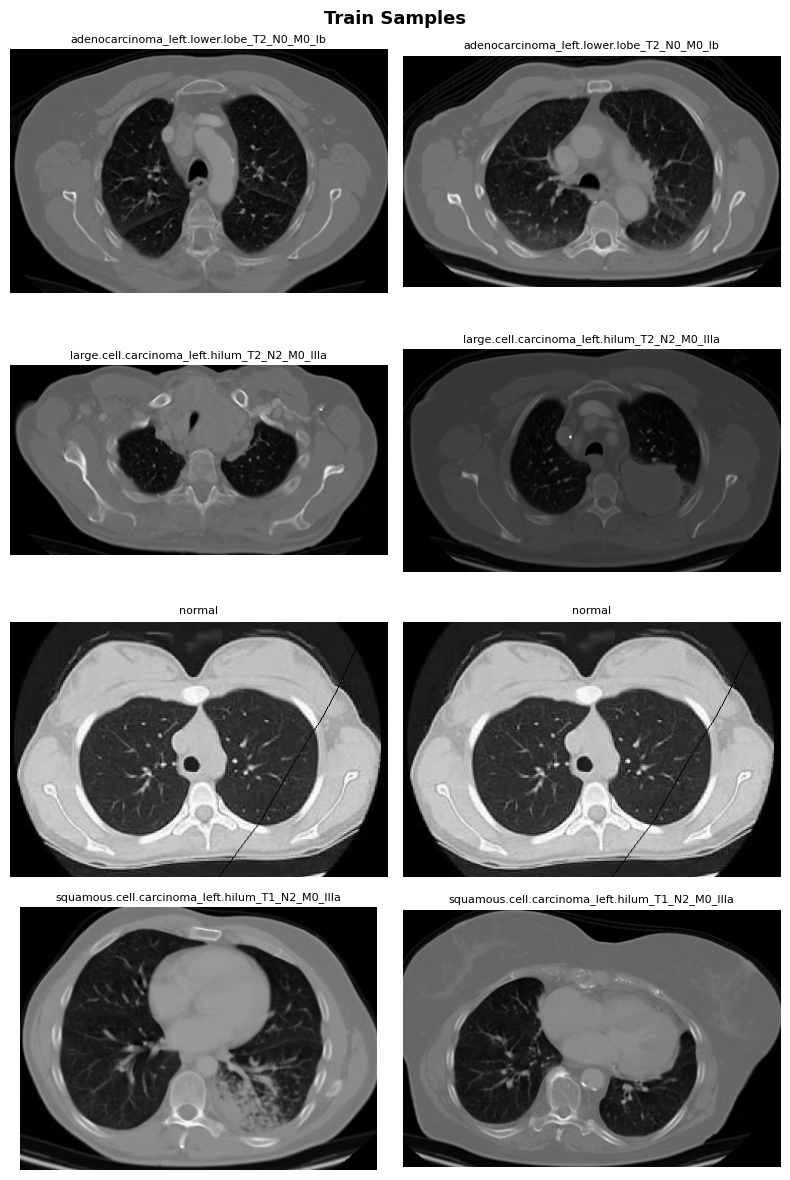

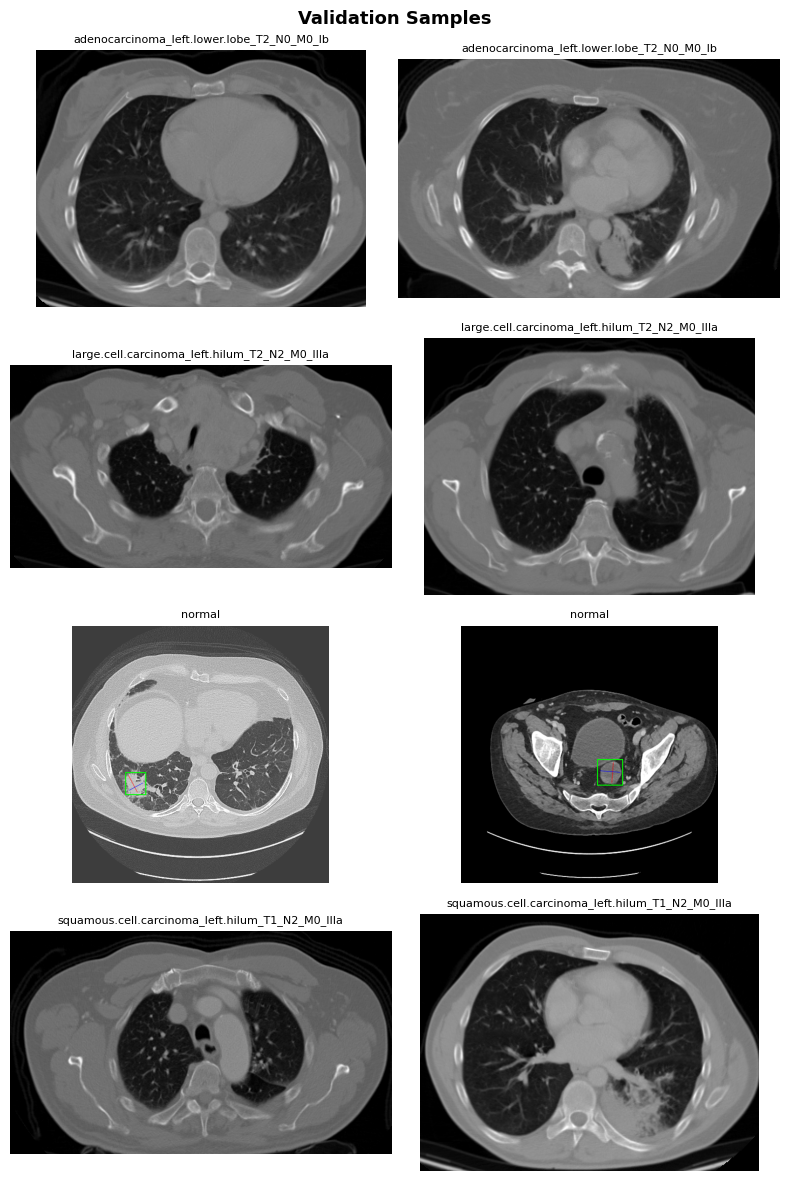

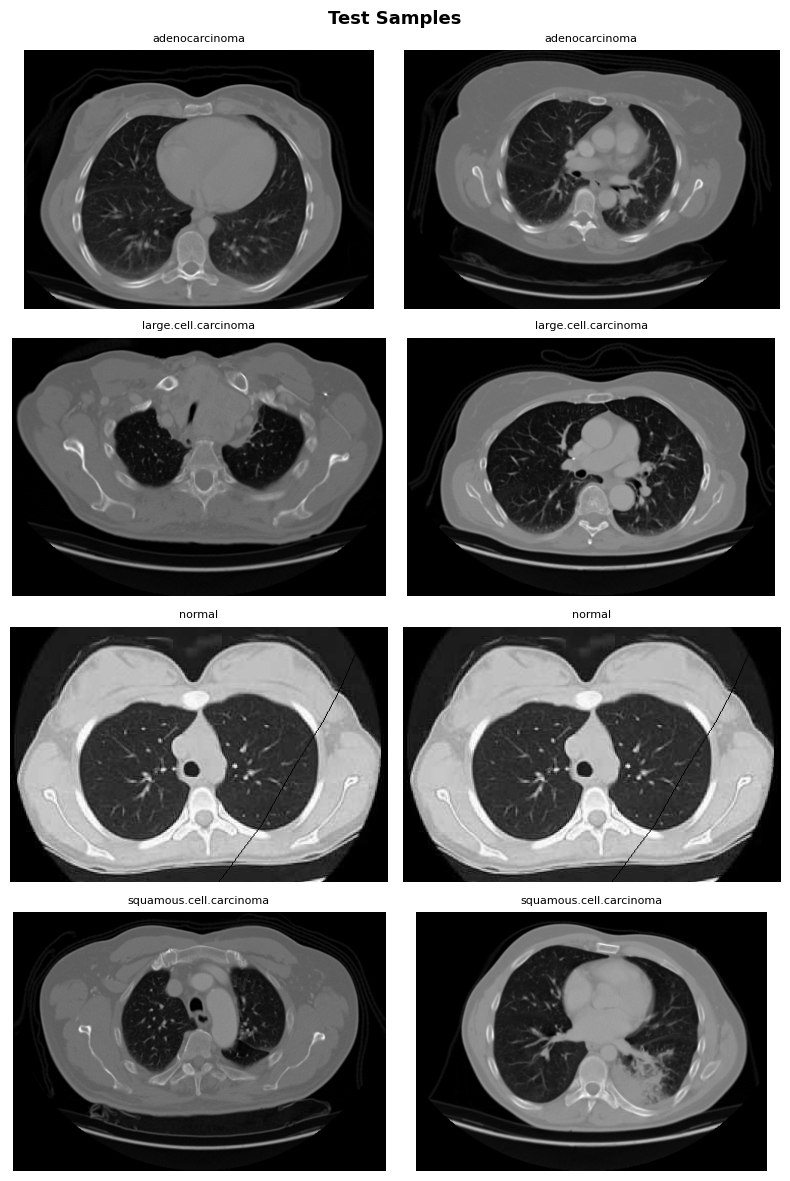

In [22]:
def show_sample_grid(folder, title, n=2):
    ds = datasets.ImageFolder(folder)
    ci = {i: [] for i in range(len(ds.classes))}
    for idx, (path, lbl) in enumerate(ds.samples):
        if len(ci[lbl]) < n: ci[lbl].append(idx)
    fig, axes = plt.subplots(len(ds.classes), n, figsize=(n*4, len(ds.classes)*3))
    fig.suptitle(title, fontsize=13, fontweight="bold")
    for row, (cls_idx, idxs) in enumerate(ci.items()):
        for col, img_idx in enumerate(idxs):
            img_path, _ = ds.samples[img_idx]
            img = Image.open(img_path).convert("RGB")
            ax = axes[row, col]
            ax.imshow(img); ax.set_title(ds.classes[cls_idx], fontsize=8); ax.axis("off")
    plt.tight_layout()
    slug = title.lower().replace(" ", "_")
    plt.savefig(os.path.join(cfg.OUTPUT_DIR, f"siglip_lc_samples_{slug}.png"), dpi=120, bbox_inches="tight")
    plt.show()

show_sample_grid(cfg.TRAIN_DIR, "Train Samples")
show_sample_grid(cfg.VAL_DIR,   "Validation Samples")
show_sample_grid(cfg.TEST_DIR,  "Test Samples")


## Dataset & DataLoaders

In [23]:
print("Loading SigLIP processor ...")
processor = SiglipProcessor.from_pretrained(cfg.CHECKPOINT)
print("Processor ready.")

train_aug = T.Compose([
    
])

class LungCancerDataset(Dataset):
    def __init__(self, folder, augment=False):
        self.base = datasets.ImageFolder(folder)
        self.aug  = train_aug if augment else None

    def __len__(self): return len(self.base)

    def __getitem__(self, idx):
        path, label = self.base.samples[idx]
        try:
            img = Image.open(path).convert("RGB")
        except Exception:
            img = Image.new("RGB", (cfg.IMG_SIZE, cfg.IMG_SIZE))
        if self.aug: img = self.aug(img)
        pv = processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)
        return pv, label

train_ds = LungCancerDataset(cfg.TRAIN_DIR, augment=True)
val_ds   = LungCancerDataset(cfg.VAL_DIR,   augment=False)
test_ds  = LungCancerDataset(cfg.TEST_DIR,  augment=False)

train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"Train:{len(train_ds)}  Val:{len(val_ds)}  Test:{len(test_ds)}")


Loading SigLIP processor ...
Processor ready.
Train:613  Val:72  Test:315


## Model

In [24]:
class SigLIPClassifier(nn.Module):
    # Uses SiglipVisionModel ONLY — never loads text encoder → no OOM
    # Freeze first `freeze_first_n` param tensors, train the rest (~50%)
    def __init__(self, checkpoint, num_classes, freeze_first_n=50):
        super().__init__()
        print(f"Loading SiglipVisionModel from '{checkpoint}' ...")
        self.encoder = SiglipVisionModel.from_pretrained(checkpoint)
        hidden = self.encoder.config.hidden_size
        print(f"Hidden size : {hidden}")

        params = list(self.encoder.named_parameters())
        total  = len(params)
        print(f"Named param tensors : {total}  |  freezing first {freeze_first_n}")
        for i, (_, p) in enumerate(params):
            p.requires_grad = (i >= freeze_first_n)

        tr = sum(p.numel() for p in self.encoder.parameters() if p.requires_grad)
        tt = sum(p.numel() for p in self.encoder.parameters())
        print(f"Encoder trainable : {tr:,} / {tt:,}  ({100*tr/tt:.1f} %)")

        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
        )
        for m in self.head.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, pixel_values):
        out = self.encoder(pixel_values=pixel_values)
        return self.head(out.pooler_output)

model = SigLIPClassifier(cfg.CHECKPOINT, cfg.NUM_CLASSES, cfg.FREEZE_FIRST_N).to(cfg.DEVICE)
gc.collect(); torch.cuda.empty_cache()
total_p = sum(p.numel() for p in model.parameters())
train_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params     : {total_p:,}")
print(f"Trainable params : {train_p:,}  ({100*train_p/total_p:.1f}%)")


Loading SiglipVisionModel from 'google/siglip-base-patch16-224' ...


Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

SiglipVisionModel LOAD REPORT from: google/siglip-base-patch16-224
Key                                                          | Status     |  | 
-------------------------------------------------------------+------------+--+-
text_model.encoder.layers.{0...11}.self_attn.q_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm2.weight        | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm1.bias          | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.v_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.k_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.v_proj.bias     | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.k_proj.bias     | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc1.bias              | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc1.weight            | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc2.weight    

Hidden size : 768
Named param tensors : 208  |  freezing first 50
Encoder trainable : 70,880,256 / 92,884,224  (76.3 %)
Total params     : 93,280,004
Trainable params : 71,276,036  (76.4%)


## Loss / Optimizer / Scheduler

In [25]:
targets = [lbl for _, lbl in train_ds.base.samples]
counts  = np.bincount(targets, minlength=cfg.NUM_CLASSES).astype(float)
weights = torch.tensor(1.0 / (counts + 1e-6), dtype=torch.float32)
weights = (weights / weights.sum() * cfg.NUM_CLASSES).to(cfg.DEVICE)
print("Class weights:", weights.cpu().numpy())

criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.AdamW([
    {"params": [p for p in model.encoder.parameters() if p.requires_grad],
     "lr": cfg.LEARNING_RATE},
    {"params": model.head.parameters(), "lr": cfg.LEARNING_RATE * 10},
], weight_decay=cfg.WEIGHT_DECAY)

scheduler = CosineAnnealingLR(optimizer, T_max=cfg.NUM_EPOCHS, eta_min=1e-7)
print(f"Backbone LR={cfg.LEARNING_RATE}  Head LR={cfg.LEARNING_RATE*10}")


Class weights: [0.7588284  1.286709   0.9998077  0.95465505]
Backbone LR=5e-05  Head LR=0.0005


## Training Loop

In [26]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler, accum):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    optimizer.zero_grad()
    for step, (pv, labels) in enumerate(tqdm(loader, desc="Train", leave=False)):
        pv, labels = pv.to(device), labels.to(device)
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(pv)
            loss   = criterion(logits, labels) / accum
        scaler.scale(loss).backward()
        if (step + 1) % accum == 0 or (step + 1) == len(loader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
        running_loss += loss.item() * accum * pv.size(0)
        correct      += (logits.argmax(1) == labels).sum().item()
        total        += pv.size(0)
    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_probs, all_preds, all_labels = [], [], []
    for pv, labels in tqdm(loader, desc="Eval ", leave=False):
        pv, labels = pv.to(device), labels.to(device)
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(pv)
            loss   = criterion(logits, labels)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(1)
        running_loss += loss.item() * pv.size(0)
        correct      += (preds == labels).sum().item()
        total        += pv.size(0)
        all_probs.append(probs.cpu()); all_preds.append(preds.cpu()); all_labels.append(labels.cpu())
    return (running_loss / total, correct / total,
            torch.cat(all_probs).numpy(),
            torch.cat(all_preds).numpy(),
            torch.cat(all_labels).numpy())


In [27]:
scaler = torch.amp.GradScaler("cuda", enabled=(cfg.DEVICE.type == "cuda"))

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_loss   = float("inf")
best_model_path = os.path.join(cfg.OUTPUT_DIR, "siglip_lc_best.pth")

# Early stopping
patience         = 5
patience_counter = 0

for epoch in range(1, cfg.NUM_EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, cfg.DEVICE, scaler, cfg.GRAD_ACCUM)
    va_loss, va_acc, _, _, _ = evaluate(model, val_loader, criterion, cfg.DEVICE)
    scheduler.step()
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        tag = "  <- saved"
    else:
        patience_counter += 1
        tag = f"  (no improvement {patience_counter}/{patience})"

    print(f"Epoch [{epoch:02d}/{cfg.NUM_EPOCHS}]  "
          f"Train Loss={tr_loss:.4f} Acc={tr_acc:.4f}  |  "
          f"Val Loss={va_loss:.4f} Acc={va_acc:.4f}{tag}")

    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after epoch {epoch} (patience={patience}).")
        break

print(f"\nBest val loss: {best_val_loss:.4f}")


Epoch [01/25]  Train Loss=1.0723 Acc=0.4649  |  Val Loss=0.8981 Acc=0.5278  <- saved


Epoch [02/25]  Train Loss=0.7444 Acc=0.6672  |  Val Loss=0.8884 Acc=0.6389  <- saved


Epoch [03/25]  Train Loss=0.4889 Acc=0.8597  |  Val Loss=1.6659 Acc=0.7083  (no improvement 1/5)


Epoch [04/25]  Train Loss=0.3905 Acc=0.8777  |  Val Loss=1.8264 Acc=0.5278  (no improvement 2/5)


Epoch [05/25]  Train Loss=0.3100 Acc=0.9184  |  Val Loss=1.6050 Acc=0.7639  (no improvement 3/5)


Epoch [06/25]  Train Loss=0.1692 Acc=0.9608  |  Val Loss=1.1668 Acc=0.8056  (no improvement 4/5)


Epoch [07/25]  Train Loss=0.0898 Acc=0.9788  |  Val Loss=1.4549 Acc=0.7917  (no improvement 5/5)

Early stopping triggered after epoch 7 (patience=5).

Best val loss: 0.8884


In [28]:
model.load_state_dict(torch.load(best_model_path, map_location=cfg.DEVICE))
print("Loaded best checkpoint.")
_, val_acc, val_probs, val_preds, val_labels = evaluate(model, val_loader,  criterion, cfg.DEVICE)
_, tst_acc, tst_probs, tst_preds, tst_labels = evaluate(model, test_loader, criterion, cfg.DEVICE)
print(f"Val  Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {tst_acc:.4f}")


Loaded best checkpoint.


Val  Accuracy: 0.6389
Test Accuracy: 0.6889


## Training Curves

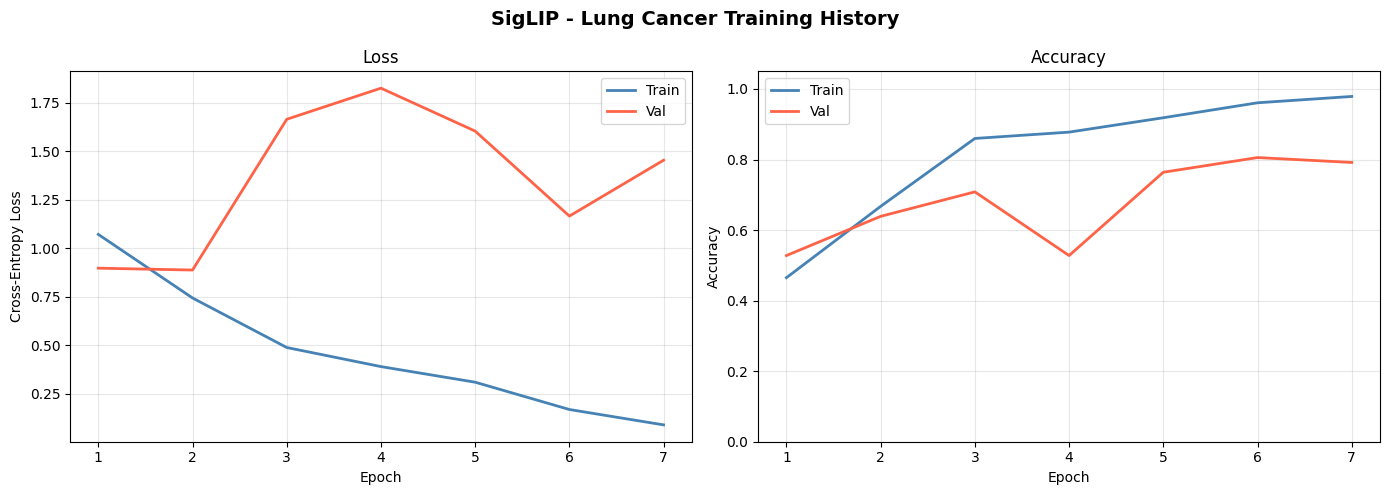

In [29]:
ep = range(1, len(history["train_loss"]) + 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("SigLIP - Lung Cancer Training History", fontsize=14, fontweight="bold")
axes[0].plot(ep, history["train_loss"], label="Train", color="steelblue", lw=2)
axes[0].plot(ep, history["val_loss"],   label="Val",   color="tomato",    lw=2)
axes[0].set_title("Loss"); axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Cross-Entropy Loss")
axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].plot(ep, history["train_acc"], label="Train", color="steelblue", lw=2)
axes[1].plot(ep, history["val_acc"],   label="Val",   color="tomato",    lw=2)
axes[1].set_title("Accuracy"); axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0, 1.05); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_lc_training_curves.png"), dpi=150, bbox_inches="tight")
plt.show()


## Confusion Matrices

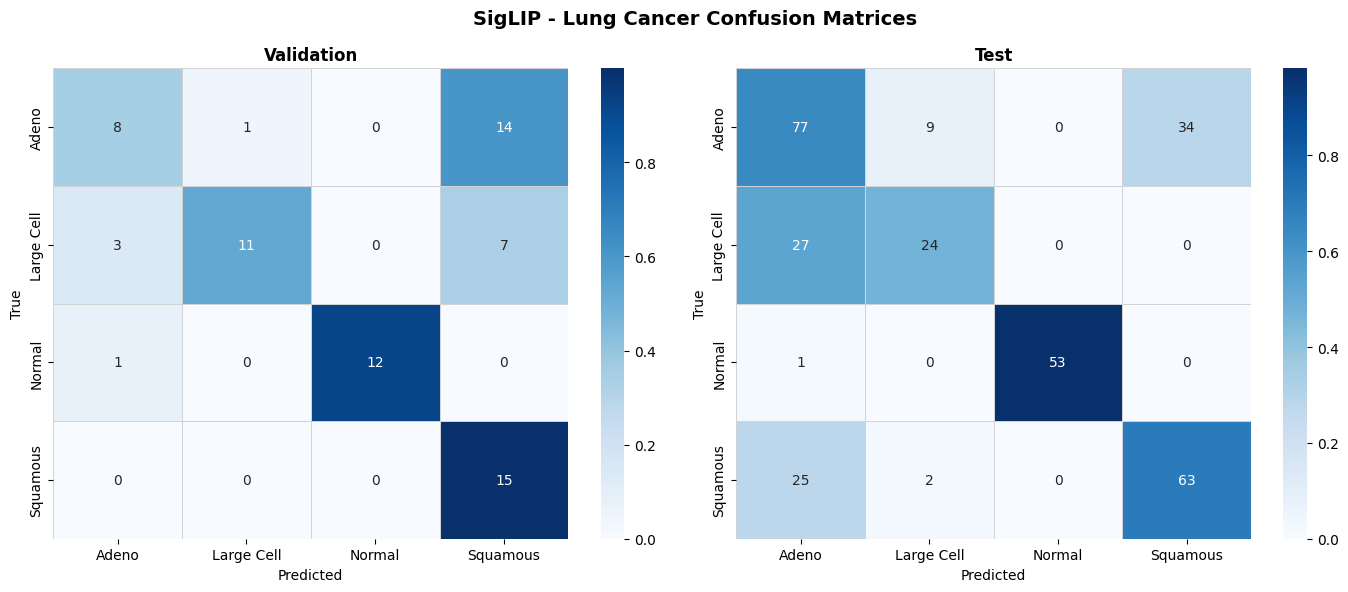

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("SigLIP - Lung Cancer Confusion Matrices", fontsize=14, fontweight="bold")
for ax, (preds, labels, title) in zip(axes, [
        (val_preds, val_labels, "Validation"),
        (tst_preds, tst_labels, "Test")]):
    cm = confusion_matrix(labels, preds)
    cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-6)
    sns.heatmap(cm_norm, annot=cm, fmt="d", cmap="Blues", ax=ax,
                xticklabels=cfg.SHORT_NAMES, yticklabels=cfg.SHORT_NAMES,
                linewidths=0.5, linecolor="lightgrey")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_lc_confusion_matrices.png"), dpi=150, bbox_inches="tight")
plt.show()


## Classification Reports

In [31]:
reports = []
for split_name, preds, labels in [("Validation", val_preds, val_labels),
                                   ("Test",       tst_preds, tst_labels)]:
    print(f"\n{'='*60}\n  {split_name} Report\n{'='*60}")
    print(classification_report(labels, preds, target_names=cfg.CLASS_NAMES))
    for i, cls in enumerate(cfg.CLASS_NAMES):
        b_true = (labels == i).astype(int)
        b_pred = (preds  == i).astype(int)
        reports.append({
            "Split": split_name, "Class": cls,
            "Accuracy":  accuracy_score(b_true, b_pred),
            "Precision": precision_score(b_true, b_pred, zero_division=0),
            "Recall":    recall_score(b_true, b_pred, zero_division=0),
            "F1-Score":  f1_score(b_true, b_pred, zero_division=0),
        })

reports_df = pd.DataFrame(reports)
reports_df.to_csv(os.path.join(cfg.OUTPUT_DIR, "siglip_lc_reports.csv"), index=False)
print(reports_df.to_string(index=False))



  Validation Report
                         precision    recall  f1-score   support

         Adenocarcinoma       0.67      0.35      0.46        23
   Large Cell Carcinoma       0.92      0.52      0.67        21
                 Normal       1.00      0.92      0.96        13
Squamous Cell Carcinoma       0.42      1.00      0.59        15

               accuracy                           0.64        72
              macro avg       0.75      0.70      0.67        72
           weighted avg       0.75      0.64      0.64        72


  Test Report
                         precision    recall  f1-score   support

         Adenocarcinoma       0.59      0.64      0.62       120
   Large Cell Carcinoma       0.69      0.47      0.56        51
                 Normal       1.00      0.98      0.99        54
Squamous Cell Carcinoma       0.65      0.70      0.67        90

               accuracy                           0.69       315
              macro avg       0.73      0.70     

## ROC Curves

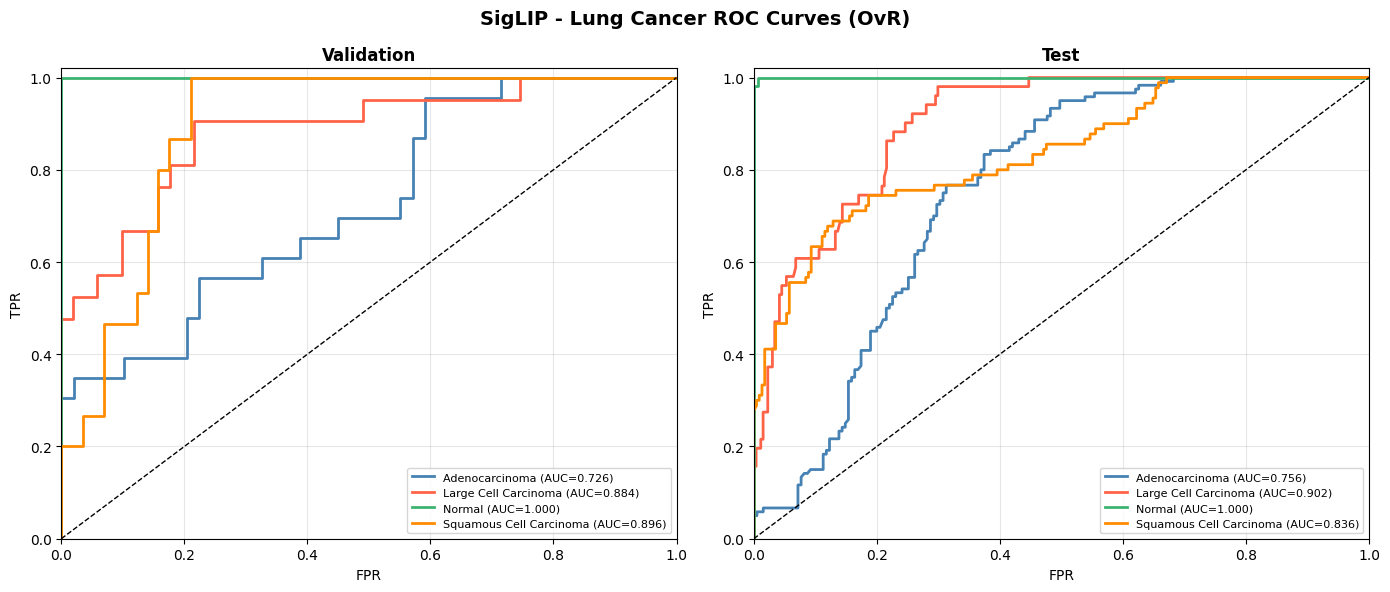

In [32]:
palette = ["steelblue", "tomato", "mediumseagreen", "darkorange"]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("SigLIP - Lung Cancer ROC Curves (OvR)", fontsize=14, fontweight="bold")
for ax, (probs, labels, title) in zip(axes, [
        (val_probs, val_labels, "Validation"),
        (tst_probs, tst_labels, "Test")]):
    lb = label_binarize(labels, classes=list(range(cfg.NUM_CLASSES)))
    for i, (cls, color) in enumerate(zip(cfg.CLASS_NAMES, palette)):
        fpr, tpr, _ = roc_curve(lb[:, i], probs[:, i])
        ax.plot(fpr, tpr, color=color, lw=2, label=f"{cls} (AUC={auc(fpr,tpr):.3f})")
    ax.plot([0,1],[0,1],"k--",lw=1)
    ax.set_xlim([0,1]); ax.set_ylim([0,1.02])
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.legend(loc="lower right", fontsize=8); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_lc_roc_curves.png"), dpi=150, bbox_inches="tight")
plt.show()


## Per-Class Metrics Comparison

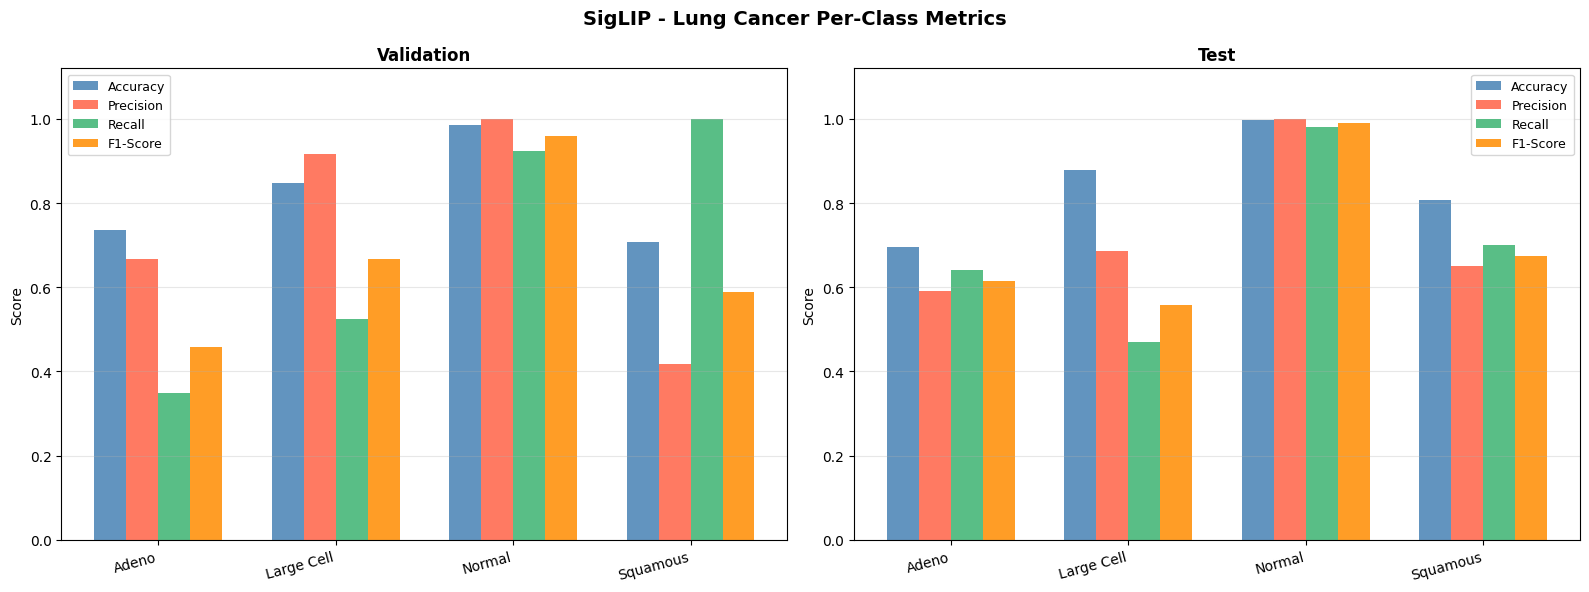

In [33]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
mc = ["steelblue", "tomato", "mediumseagreen", "darkorange"]
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("SigLIP - Lung Cancer Per-Class Metrics", fontsize=14, fontweight="bold")
for ax, split in zip(axes, ["Validation", "Test"]):
    sub = reports_df[reports_df["Split"] == split]
    x = np.arange(len(cfg.CLASS_NAMES)); w = 0.18
    for j, (met, col) in enumerate(zip(metrics, mc)):
        vals = [sub.loc[sub["Class"]==cls, met].values[0] for cls in cfg.CLASS_NAMES]
        ax.bar(x + j*w, vals, w, label=met, color=col, alpha=0.85)
    ax.set_xticks(x + w*1.5); ax.set_xticklabels(cfg.SHORT_NAMES, rotation=15, ha="right")
    ax.set_ylim(0, 1.12); ax.set_ylabel("Score")
    ax.set_title(split, fontsize=12, fontweight="bold")
    ax.legend(fontsize=9); ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_lc_metrics_comparison.png"), dpi=150, bbox_inches="tight")
plt.show()


## Save & Summary

In [34]:
torch.save({
    "model_state_dict": model.state_dict(),
    "config": {"checkpoint": cfg.CHECKPOINT, "num_classes": cfg.NUM_CLASSES,
               "class_names": cfg.CLASS_NAMES, "img_size": cfg.IMG_SIZE},
    "best_val_loss": best_val_loss,
}, os.path.join(cfg.OUTPUT_DIR, "siglip_lc_final.pth"))

print("=" * 65)
print("DONE - SigLIP Lung Cancer")
print("=" * 65)
print(f"  Best Val Loss  : {best_val_loss:.4f}")
print(f"  Val  Accuracy  : {val_acc:.4f}")
print(f"  Test Accuracy  : {tst_acc:.4f}")
print("\nPer-class F1 (Test):")
ts = reports_df[reports_df["Split"] == "Test"]
for _, r in ts.iterrows():
    print(f"  {r['Class']:30s} F1={r['F1-Score']:.4f}  Acc={r['Accuracy']:.4f}")
print("\nAll outputs saved.")


DONE - SigLIP Lung Cancer
  Best Val Loss  : 0.8884
  Val  Accuracy  : 0.6389
  Test Accuracy  : 0.6889

Per-class F1 (Test):
  Adenocarcinoma                 F1=0.6160  Acc=0.6952
  Large Cell Carcinoma           F1=0.5581  Acc=0.8794
  Normal                         F1=0.9907  Acc=0.9968
  Squamous Cell Carcinoma        F1=0.6738  Acc=0.8063

All outputs saved.
